In [1]:
from numpy import array
from numpy import asarray
from numpy import zeros

import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import Bidirectional, GlobalMaxPool1D, BatchNormalization
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, f1_score
from keras.callbacks import ModelCheckpoint, EarlyStopping


import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
dir = "drive/My Drive/BT4221/Data/"
df = pd.read_csv(dir+"cleaned_train_v1.csv")
df = df.drop('Unnamed: 0', 1)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count,char_count,word_density,total_length,capitals,capitals_prop,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_unique_words,prop_unique_words,processed_text,polarity,subjectivity
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,-0.244844,-0.211930,-0.493930,-0.220419,-0.001684,0.137612,-0.025544,0.346355,-0.154764,-0.107174,-0.130716,0.768622,explanation edits made username hardcore metal...,0.272671,0.262369
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,-0.506830,-0.471943,-0.930063,-0.477701,-0.094912,0.213387,0.013059,-0.282543,-0.233058,-0.107174,-0.571564,1.131563,daww match background colour seemingly stuck t...,0.535212,-0.674041
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,-0.254920,-0.274902,0.257890,-0.272891,-0.136347,-0.371094,-0.025544,-0.282543,-0.311352,-0.107174,-0.167453,0.574190,hey man really trying edit war guy constantly ...,0.328930,0.000397
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0.460504,0.373099,0.348351,0.385547,-0.063836,-0.365520,-0.025544,-0.282543,-0.154764,-0.107174,0.622401,-1.009142,ca nt make real suggestion improvement wondere...,0.466452,-0.316384
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,-0.547136,-0.553197,0.683628,-0.553870,-0.157064,-0.234474,-0.025544,0.346355,-0.389645,-0.107174,-0.645039,1.131563,sir hero chance remember page,-0.289916,-1.409792


In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = df[labels].values

In [5]:
X = df['processed_text'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, random_state=1234)

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [8]:
embeddings_dictionary = dict()
path = "drive/My Drive/BT4221/Scripts/transformer/"
glove_file = open(path + 'glove.twitter.27B.200d.txt', encoding="utf8")

In [9]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [10]:
embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [11]:
inp = Input(shape=(maxlen,))
output = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(inp)
output = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(output)
output = GlobalMaxPool1D()(output)
output = BatchNormalization()(output)
output = Dense(50, activation="relu")(output)
output = Dropout(0.1)(output)
output = Dense(6, activation="sigmoid")(output)
model = Model(inputs=inp, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

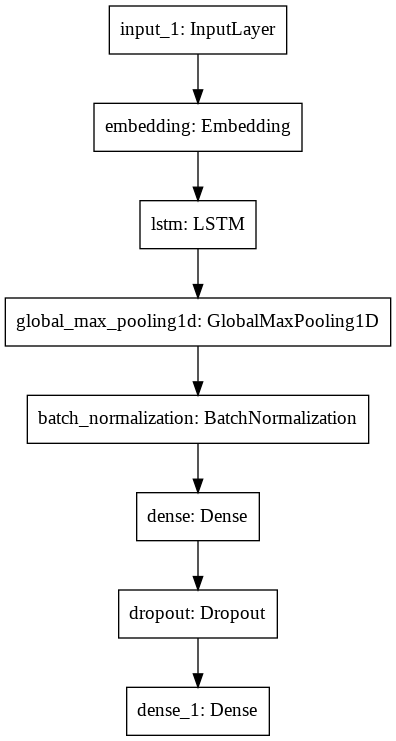

In [12]:
keras.utils.plot_model(model)

In [14]:
saved_model = "/content/drive/My Drive/BT4221/Models/singleLSTM_GloVe.best.hdf5"
history = model.fit(X_train, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
798/798 [==============================] - 585s 733ms/step - loss: 0.1014 - accuracy: 0.7844 - val_loss: 0.0609 - val_accuracy: 0.9781
Epoch 2/3
798/798 [==============================] - 583s 731ms/step - loss: 0.0547 - accuracy: 0.9155 - val_loss: 0.0530 - val_accuracy: 0.9934
Epoch 3/3
798/798 [==============================] - 583s 731ms/step - loss: 0.0503 - accuracy: 0.9491 - val_loss: 0.0516 - val_accuracy: 0.9932


In [15]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

997/997 [==============================] - 42s 42ms/step - loss: 0.0501 - accuracy: 0.9932
Test Score: 0.05006377398967743
Test Accuracy: 0.9932290315628052


In [16]:
model.save('/content/drive/My Drive/BT4221/Models/GloVe_singleLSTM.keras')

In [8]:
model = keras.models.load_model('/content/drive/My Drive/BT4221/Models/GloVe_singleLSTM.keras')

In [9]:
y_pred = model.predict(X_test)

In [10]:
thresholds = np.arange(0, 1, 0.01)

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
predictions = y_pred
# evaluate each threshold
scores_hl = [hamming_loss(y_test, to_labels(predictions, t)) for t in thresholds]
scores_f1 = [f1_score(y_test, to_labels(predictions, t), average = "macro") for t in thresholds]

# get best threshold
ix_hl = np.argmin(scores_hl)
print('Threshold={}, Min Hamming Loss={}, F1-score = {}'.format(thresholds[ix_hl], scores_hl[ix_hl], scores_f1[ix_hl]))

ix_f1 = np.argmax(scores_f1)
print('Threshold={}, Max F1-score={}, Hamming Loss = {}'.format(thresholds[ix_f1], scores_f1[ix_f1], scores_hl[ix_f1]))

Threshold=0.54, Min Hamming Loss=0.018118554277295383, F1-score = 0.481911519121673
Threshold=0.23, Max F1-score=0.6056728863437674, Hamming Loss = 0.02228247808323668


In [ ]:
# convert float to binary integer
predictions = y_pred
thresholds = [0.18]
for val in thresholds:
  y_pred_copy=predictions.copy()

  y_pred_copy[y_pred_copy>=val]=1
  y_pred_copy[y_pred_copy<val]=0
  print(val)
  print(hamming_loss(y_test, y_pred_copy))



0.18
0.021545824059851833


In [ ]:
# generate mulilabel confusion matrix
cm = multilabel_confusion_matrix(y_test, y_pred_copy)

In [ ]:
def precision_recall(cmat): 
    tp = cmat[1][1] 
    fp = cmat[1][0] 
    fn = cmat[0][1] 
    tn = cmat[0][0] 
    return tp/(tp+fp), tp/(tp+fn)

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    #compute tp, tp_and_fn and tp_and_fp w.r.t all classes
    precision, recall = precision_recall(confusion_matrix)

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

    print(class_label)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print()

toxic
Precision: 0.8089637635092181
Recall: 0.7417662489070241

severe_toxic
Precision: 0.5173501577287066
Recall: 0.39902676399026765

obscene
Precision: 0.8569794050343249
Recall: 0.7584810126582279

threat
Precision: 0.375
Recall: 0.4235294117647059

insult
Precision: 0.8403519798868636
Recall: 0.6060743427017226

identity_hate
Precision: 0.5105633802816901
Recall: 0.5105633802816901



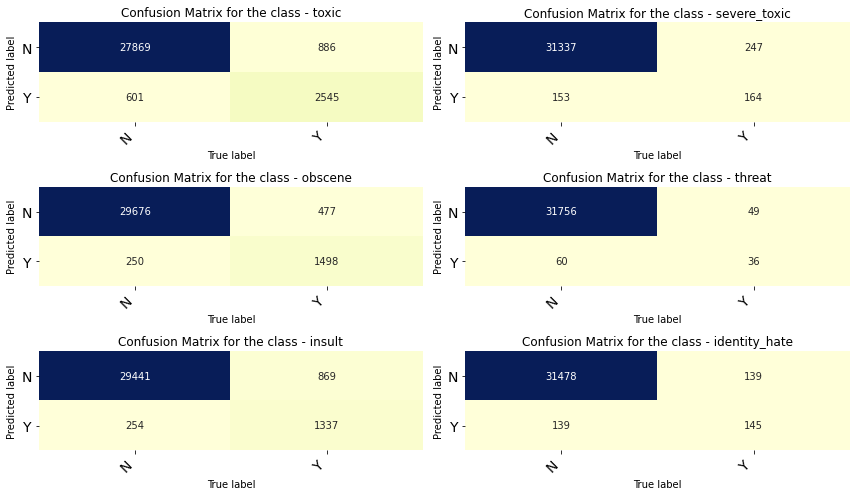

In [ ]:
# use threshold 0.18
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):

  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()  

toxic
Precision: 0.7116973935155754
Recall: 0.8718847352024922

severe_toxic
Precision: 0.12933753943217666
Recall: 0.5694444444444444

obscene
Precision: 0.7488558352402745
Recall: 0.870345744680851

threat
Precision: 0.16666666666666666
Recall: 0.5925925925925926

insult
Precision: 0.700188560653677
Recall: 0.7319316688567674

identity_hate
Precision: 0.2746478873239437
Recall: 0.6554621848739496



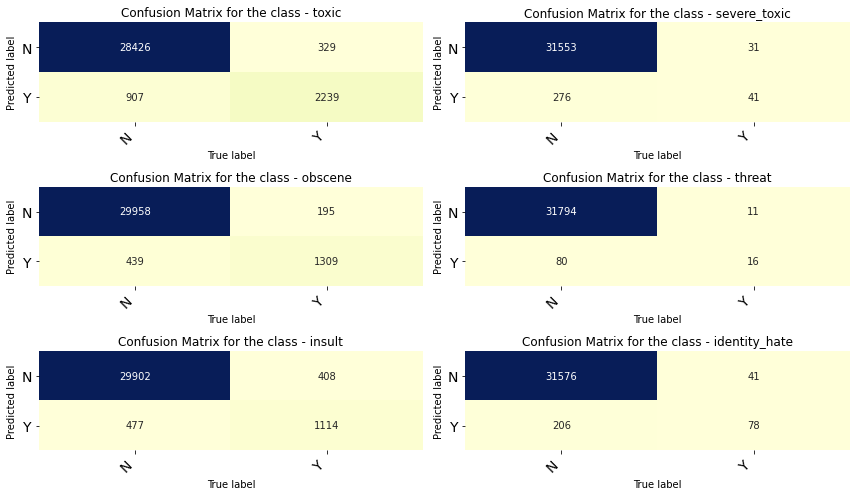

In [ ]:
# use threshold 0.42
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):

  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()  

toxic
Precision: 0.9918970613806295
Recall: 0.965669014084507

severe_toxic
Precision: 0.9998100303951368
Recall: 0.9905269761606023

obscene
Precision: 0.9949922064139555
Recall: 0.9835108998524832

threat
Precision: 0.9997484672221348
Recall: 0.997396486825596

insult
Precision: 0.9893434510062685
Recall: 0.9815711947626842

identity_hate
Precision: 0.9993358003605656
Recall: 0.9927732042983723



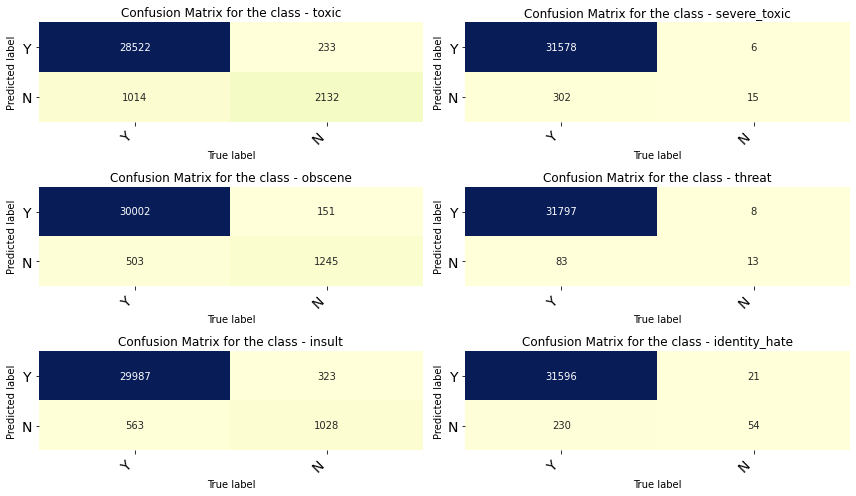

In [ ]:
# use threshold 0.5
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):

  print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])

fig.tight_layout()
plt.show()  